## Sampling: Emcee Hammer MCMC

This example shows you how to perform Bayesian inference on a time series, using [emcee hammer MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/emcee_hammer_mcmc.html) as introduced in [1].

It follows on from the [first sampling example](./sampling-first-example.ipynb).

[1] "emcee: The MCMC Hammer", Daniel Foreman-Mackey, David W. Hogg,
    Dustin Lang, Jonathan Goodman, 2013, arXiv, 
    https://arxiv.org/pdf/1202.3665.pdf

In [7]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [real_parameters * (1 + 0.1 * np.random.rand()) for i in range(num_chains)]

# Create mcmc routine
mcmc = pints.MCMCSampling(
    log_posterior, num_chains, xs, method=pints.EmceeHammerMCMC)

# Add stopping criterion
mcmc.set_max_iterations(6000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(500)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Emcee Hammer MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     4       0:00.0
2     5       0:00.0
3     6       0:00.0
500   503     0:00.1
1000  1003    0:00.2
1500  1503    0:00.3
2000  2003    0:00.4
2500  2503    0:00.5
3000  3003    0:00.6
3500  3503    0:00.7
4000  4003    0:00.8
4500  4503    0:01.0
5000  5003    0:01.1
5500  5503    0:01.2
6000  6002    0:01.3
Halting: Maximum number of iterations (6000) reached.
Done!


R-hat:
[1.006296082719662, 1.0000371934135943, 1.000374761610463]


/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


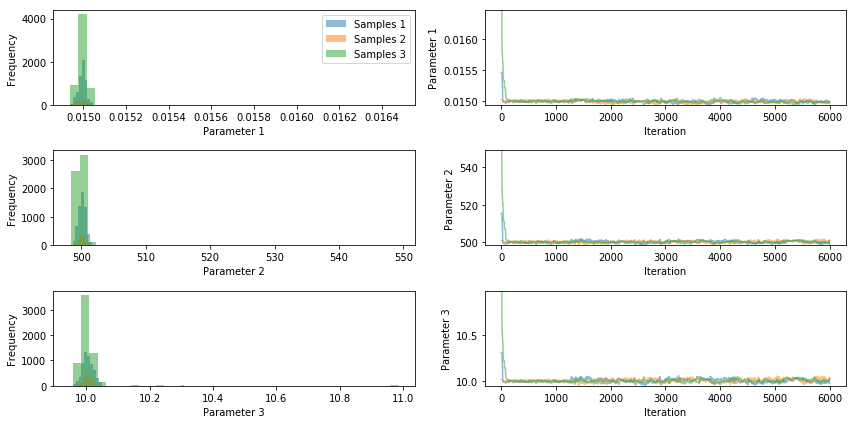

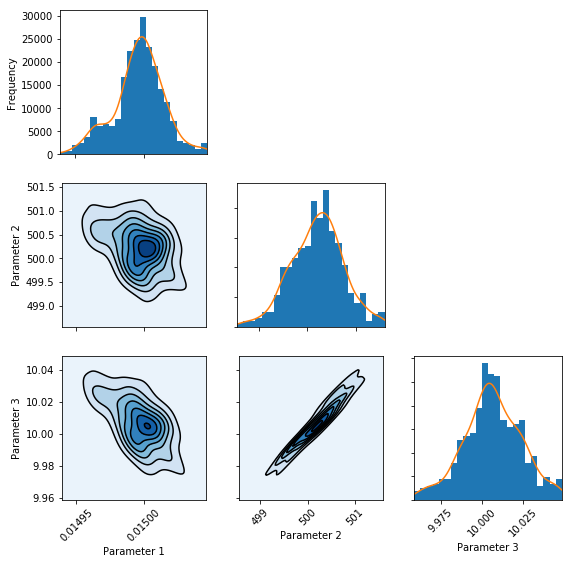

In [8]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500:, :]

# Apply thinning
chains = chains[:, ::10]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()